Loaded 23 photons from detections/photon_tables/photons_30892.csv

=== Minimal Variability Timescale (single ObsID) ===
Bayesian Blocks MVT     : 736.571 s (2 blocks)


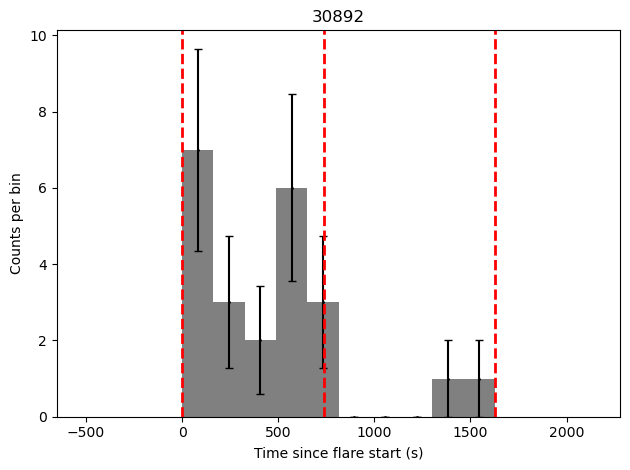

In [6]:
import numpy as np
import pandas as pd
from astropy.stats import bayesian_blocks
import matplotlib.pyplot as plt


# ---------------------------------------
#  Minimal Variability Timescale (single ObsID)
# ---------------------------------------

def mvt_bayesian_blocks(times_s, p0=0.05):
    """
    Estimate minimal variability timescale using Bayesian Blocks.
    Returns (mvt_seconds, block_edges)
    """
    t = np.asarray(times_s, dtype=float)
    if len(t) < 3:
        return np.nan, np.array([])

    edges = bayesian_blocks(t, fitness='events', p0=p0)
    widths = np.diff(edges)
    mvt = np.min(widths) if len(widths) else np.nan
    return mvt, edges

def mvt_n_photon_window(times_s, k=5):
    """
    Estimate minimal timescale as shortest time interval with k photons.
    Returns (mvt_seconds, start_time, end_time)
    """
    t = np.sort(np.asarray(times_s, dtype=float))
    n = len(t)
    if n < k:
        return np.nan, np.nan, np.nan

    dt = t[k-1:] - t[:n-k+1]
    i = np.argmin(dt)
    return dt[i], t[i], t[i + k - 1]
# -------------------------------------------------------
# Load one photon CSV (inside 1.5×R90 region)
# -------------------------------------------------------
obsid = "30892"

csv_path = f"detections/photon_tables/photons_{obsid}.csv"  # <--- change to your file

df = pd.read_csv(csv_path)

print(f"Loaded {len(df)} photons from {csv_path}")

times_s = df["Time_s_since_obs_start"].values

# --- Bayesian Blocks ---
mvt_bb, edges = mvt_bayesian_blocks(times_s, p0=0.05)

# --- N-photon window ---
mvt_k, t0_k, t1_k = mvt_n_photon_window(times_s, k=5)



binsize = 150.0
tmin, tmax = np.min(times_s), np.max(times_s)

bins = np.arange(tmin, tmax + binsize, binsize)


# binned light curve (counts/bin)
counts, _ = np.histogram(times_s, bins=bins)
centers = 0.5*(bins[1:] + bins[:-1])



# --- Print summary ---
print("\n=== Minimal Variability Timescale (single ObsID) ===")
print(f"Bayesian Blocks MVT     : {mvt_bb:.3f} s ({len(edges)-1} blocks)")


# --- Histogram ---
counts, bins, _ = plt.hist(times_s, bins=10, color="grey")

# --- Bin centers ---
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# --- Poisson uncertainties ---
errors = np.sqrt(counts)

# --- Overlay error bars ---
plt.errorbar(
    bin_centers,
    counts,
    yerr=errors,
    fmt='o',
    color='black',
    ecolor='black',
    capsize=3,
    markersize=1,
    linestyle='none'
)

# --- Bayesian Block edges ---
for e in edges:
    plt.axvline(e, color="red", ls="--", lw=2)

pad = 0.4 * (tmax - tmin)
plt.xlim(tmin - pad, tmax + pad)


plt.xlabel("Time since flare start (s)")
plt.ylabel("Counts per bin")
plt.title(f"{obsid}")
plt.tight_layout()
plt.savefig(f"BB_MVT_{obsid}.png", dpi=300)
plt.show()




Observed BB MVT: 2730.82 s

=== Parametric Bootstrap MVT Uncertainty ===
Bootstrap samples used: 999
Observed MVT (data): 2730.82 s
Median MVT (sim):    2247.90 s
1σ interval:         1693.18 – 2517.71 s
90% interval:        244.96 – 2636.16 s


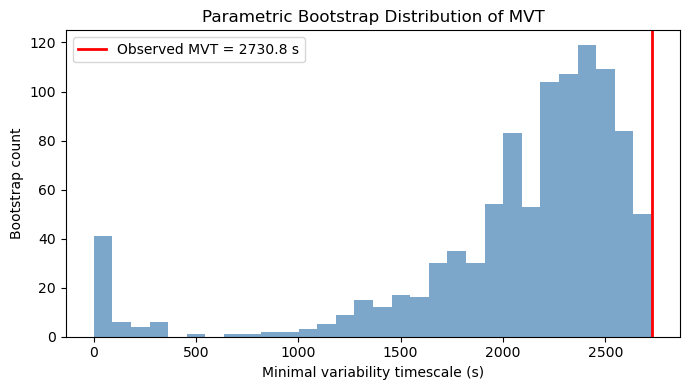

In [18]:
import numpy as np
from astropy.stats import bayesian_blocks
import matplotlib.pyplot as plt

def mvt_bayesian_blocks(times_s, p0=0.05):
    t = np.asarray(times_s, dtype=float)
    if len(t) < 2:
        return np.nan, np.array([])
    edges = bayesian_blocks(t, fitness='events', p0=p0)
    widths = np.diff(edges)
    if len(widths) == 0:
        return np.nan, edges
    return np.min(widths), edges


def fit_bb_model(times_s, p0=0.05):
    """Fit Bayesian Blocks and return edges, widths, and block event counts & rates."""
    t = np.asarray(times_s, dtype=float)
    mvt, edges = mvt_bayesian_blocks(t, p0=p0)
    widths = np.diff(edges)

    # counts per block
    counts_per_block = []
    for i in range(len(widths)):
        in_block = (t >= edges[i]) & (t < edges[i+1])
        counts_per_block.append(in_block.sum())
    counts_per_block = np.array(counts_per_block)

    rates = counts_per_block / widths  # events per second
    return mvt, edges, widths, counts_per_block, rates


def simulate_from_bb_model(edges, widths, rates, rng):
    """Simulate event times from a piecewise-constant Poisson process."""
    sim_times = []

    for i in range(len(widths)):
        dt = widths[i]
        lam = rates[i]

        mean_counts = lam * dt
        n_events = rng.poisson(mean_counts)

        # Uniformly distribute events within the block
        if n_events > 0:
            u = rng.random(n_events)
            block_times = edges[i] + u * dt
            sim_times.append(block_times)

    if len(sim_times) == 0:
        return np.array([])
    sim_times = np.concatenate(sim_times)
    sim_times.sort()
    return sim_times


def parametric_bootstrap_mvt(times_s, n_boot=1000, p0=0.05, random_seed=123):
    rng = np.random.default_rng(random_seed)

    # Fit BB model once to the real data
    mvt_obs, edges, widths, counts_per_block, rates = fit_bb_model(times_s, p0=p0)
    print(f"Observed BB MVT: {mvt_obs:.2f} s")

    mvt_samples = []

    for _ in range(n_boot):
        sim_times = simulate_from_bb_model(edges, widths, rates, rng)
        if len(sim_times) < 2:
            mvt_samples.append(np.nan)
            continue

        mvt_sim, _ = mvt_bayesian_blocks(sim_times, p0=p0)
        mvt_samples.append(mvt_sim)

    return mvt_obs, np.array(mvt_samples)


# --------------------------------------------------
# Run parametric bootstrap
# --------------------------------------------------

n_boot = 1000
p0 = 0.05

mvt_obs, mvt_samples = parametric_bootstrap_mvt(times_s, n_boot=n_boot, p0=p0)

# Remove NaNs if any
mvt_samples = mvt_samples[~np.isnan(mvt_samples)]

median_mvt = np.nanmedian(mvt_samples)
mvt_1sigma_low = np.nanpercentile(mvt_samples, 16)
mvt_1sigma_high = np.nanpercentile(mvt_samples, 84)
mvt_90_low = np.nanpercentile(mvt_samples, 5)
mvt_90_high = np.nanpercentile(mvt_samples, 95)

print("\n=== Parametric Bootstrap MVT Uncertainty ===")
print(f"Bootstrap samples used: {len(mvt_samples)}")
print(f"Observed MVT (data): {mvt_obs:.2f} s")
print(f"Median MVT (sim):    {median_mvt:.2f} s")
print(f"1σ interval:         {mvt_1sigma_low:.2f} – {mvt_1sigma_high:.2f} s")
print(f"90% interval:        {mvt_90_low:.2f} – {mvt_90_high:.2f} s")

# Optional: plot distribution
plt.figure(figsize=(7,4))
plt.hist(mvt_samples, bins=30, color="steelblue", alpha=0.7)
plt.axvline(mvt_obs, color="red", lw=2, label=f"Observed MVT = {mvt_obs:.1f} s")
plt.xlabel("Minimal variability timescale (s)")
plt.ylabel("Bootstrap count")
plt.title("Parametric Bootstrap Distribution of MVT")
plt.legend()
plt.tight_layout()
plt.show()
